In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"

In [28]:
from math import ceil
from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp
from jax import random

from tqdm import tqdm


from functools import partial
from jax import jit

In [3]:
from bpd.pipelines import pipeline_toy_ellips, pipeline_shear_inference_simple


# Low shape noise and pixel noise

In [4]:
seed = 42
key = random.key(seed)

g1 = 0.02
g2 = 0.0
true_g = jnp.array([g1, g2])

sigma_e = 1e-3
sigma_e_int = 4e-2
sigma_m = 1e-5
n_gals = 1000
n_samples_per_gal = 300

In [8]:
k1, k2 = random.split(key)

In [25]:
# positive shear
e1e2p, _, _ = pipeline_toy_ellips(k1, g1=g1, g2=g2, sigma_e=sigma_e, sigma_e_int=sigma_e_int, sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [26]:
# negative shear (same key!)
e1e2m, _, _ = pipeline_toy_ellips(k1, g1=-g1, g2=-g2, 
                                       sigma_e=sigma_e, sigma_e_int=sigma_e_int, sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [28]:
e1e2p.shape, e1e2m.shape

((1000, 300, 2), (1000, 300, 2))

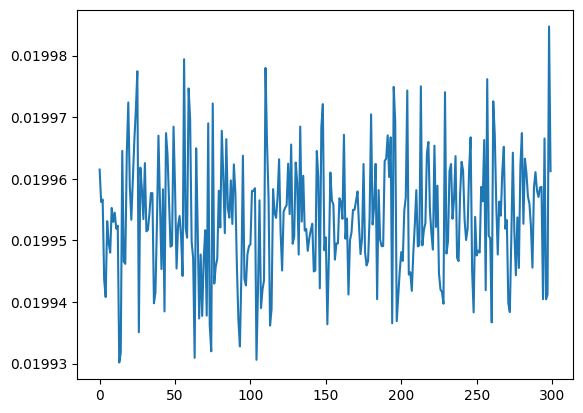

In [29]:
plt.plot(e1e2p[3, :, 0])

100

In [35]:
_pipe = partial(pipeline_shear_inference_simple,
                init_g=jnp.array([0.0,0.0]),
                sigma_e=sigma_e, 
                sigma_e_int=sigma_e_int,
                n_samples=3000,
                initial_step_size=0.01
               )
pipe = jit(_pipe)

In [36]:
e1e2p.shape

(1000, 300, 2)

In [37]:
gp_full = pipe(k2, e1e2p)

In [38]:
gm_full = pipe(k2, e1e2m)

In [40]:
gp_full.shape, gm_full.shape

((3000, 2), (3000, 2))

(array([ 22.,  95., 280., 611., 849., 655., 338., 117.,  28.,   5.]),
 array([0.01988095, 0.01990287, 0.01992478, 0.0199467 , 0.01996862,
        0.01999054, 0.02001245, 0.02003437, 0.02005629, 0.02007821,
        0.02010012]),
 <BarContainer object of 10 artists>)

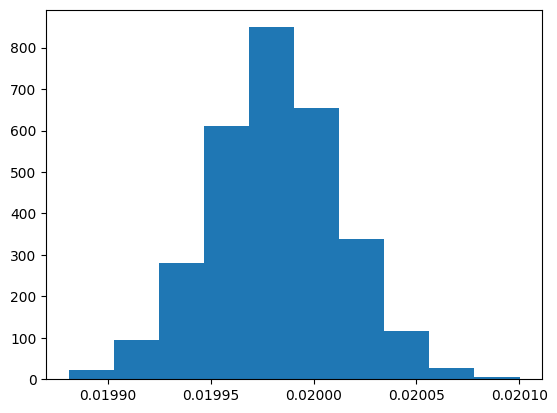

In [41]:
plt.hist(gp_full[:,0])

In [44]:
1000 / 10

100.0

In [86]:
# shear with jackknife 
batch_size = 50 
n_splits = int(n_gals / batch_size)
n_splits

gps = [] 
gms = [] 

k2s = random.split(k2, n_splits) 

for ii in tqdm(range(n_splits)):
    start, end = batch_size * ii, batch_size * (ii+1)
    _e1e2p = jnp.concatenate([e1e2p[:start], e1e2p[end:]], axis=0)
    _e1e2m = jnp.concatenate([e1e2m[:start], e1e2m[end:]], axis=0)

    assert _e1e2p.shape[0] == n_gals - batch_size
    assert _e1e2m.shape[0] == n_gals - batch_size

    
    _gp = pipe(k2s[ii], _e1e2p)
    _gm = pipe(k2s[ii], _e1e2m)

    gps.append(_gp)
    gms.append(_gm)
    
    

100%|██████████| 20/20 [02:43<00:00,  8.16s/it]


In [87]:
gps_ = jnp.stack(gps, axis=0)
gms_ = jnp.stack(gms, axis=0)

In [88]:
# jnp.save("gp_jack.npy", gps_)
# jnp.save("gm_jack.npy", gms_)

In [89]:
gps_.shape

(20, 3000, 2)

In [90]:
mjack = (gps_[...,0].mean(axis=1) - gms_[...,0].mean(axis=1)) / 2 / 0.02 - 1

In [95]:
jnp.sqrt(mjack.var() * 19)

Array(2.24736162e-05, dtype=float64)

(array([1., 0., 1., 1., 1., 0., 1., 6., 8., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.]),
 array([-2.14189592e-05, -2.00573666e-05, -1.86957740e-05, -1.73341814e-05,
        -1.59725888e-05, -1.46109962e-05, -1.32494036e-05, -1.18878110e-05,
        -1.05262184e-05, -9.16462575e-06, -7.80303314e-06, -6.44144054e-06,
        -5.07984793e-06, -3.71825533e-06, -2.35666272e-06, -9.95070114e-07,
         3.66522492e-07,  1.72811510e-06,  3.08970770e-06,  4.45130031e-06,
         5.81289292e-06,  7.17448552e-06]),
 <BarContainer object of 21 artists>)

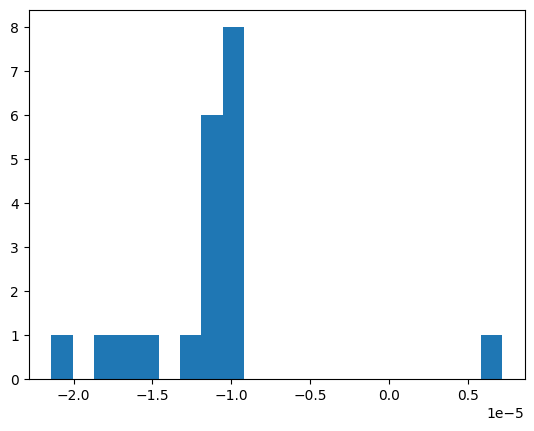

In [91]:
plt.hist(mjack, bins=21)

In [92]:
# shear with bootstrap 
n_boots = 100

gpsb = [] 
gmsb = [] 

k2s = random.split(k2, n_splits) 

for ii in tqdm(range(n_splits)):

    k_ii = k2s[ii]
    _k1, _k2 = random.split(k_ii)
    
    indices = random.randint(_k1, minval=0, maxval=n_gals, shape=(n_gals,))

    _e1e2p = e1e2p[indices]
    _e1e2m = e1e2m[indices]
    assert _e1e2p.shape[0] == n_gals
    
    _gp = pipe(_k2, _e1e2p)
    _gm = pipe(_k2, _e1e2m)

    gpsb.append(_gp)
    gmsb.append(_gm)
    
    

  0%|          | 0/20 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [73]:
gspb_ = jnp.stack(gpsb, axis=0)
gsmb_ = jnp.stack(gmsb, axis=0)
gspb_.shape

(100, 3000, 2)

In [84]:
# jnp.save("gp_boot1.npy", gspb_)
# jnp.save("gm_boot1.npy", gsmb_)

In [96]:
mboot = (gspb_[...,0].mean(axis=1) - gsmb_[...,0].mean(axis=1)) / 2 / 0.02 - 1

(array([ 3.,  0.,  3.,  8.,  6., 45., 19.,  4.,  7.,  5.]),
 array([-3.14154322e-05, -2.77387360e-05, -2.40620397e-05, -2.03853435e-05,
        -1.67086472e-05, -1.30319510e-05, -9.35525471e-06, -5.67855845e-06,
        -2.00186220e-06,  1.67483406e-06,  5.35153031e-06]),
 <BarContainer object of 10 artists>)

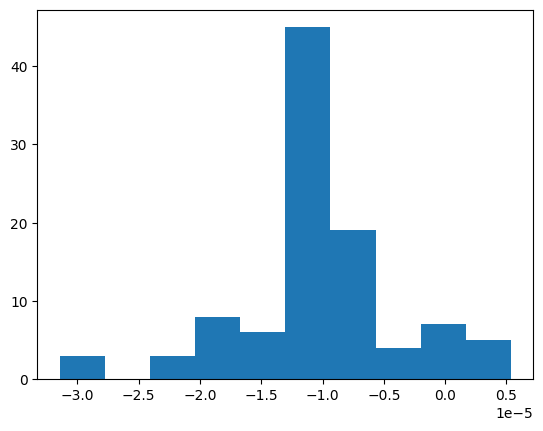

In [97]:
plt.hist(mboot)

In [100]:
mboot.mean(), mjack.mean()

(Array(-9.94488444e-06, dtype=float64), Array(-1.1122509e-05, dtype=float64))

In [102]:
mboot.std(), jnp.sqrt(mjack.var() * 19)

(Array(6.62893561e-06, dtype=float64), Array(2.24736162e-05, dtype=float64))

In [104]:
mjack.std()

Array(5.15580116e-06, dtype=float64)

# higher shape noise I 


## Standard approach

In [8]:
seed = 42
key = random.key(seed)

g1 = 0.02
g2 = 0.0
true_g = jnp.array([g1, g2])

sigma_e = 1e-2
sigma_e_int = 5e-2
sigma_m = 1e-5
n_gals = 10000
n_samples_per_gal = 300

In [9]:
k1, k2 = random.split(key)

In [10]:
# positive shear
e1e2p, _, _ = pipeline_toy_ellips(k1, g1=g1, g2=g2, 
                                  sigma_e=sigma_e, sigma_e_int=sigma_e_int, 
                                  sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [11]:
# negative shear (same key!)
e1e2m, _, _ = pipeline_toy_ellips(k1, g1=-g1, g2=-g2, 
                                  sigma_e=sigma_e, sigma_e_int=sigma_e_int, 
                                  sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [12]:
e1e2p.shape, e1e2m.shape

((10000, 300, 2), (10000, 300, 2))

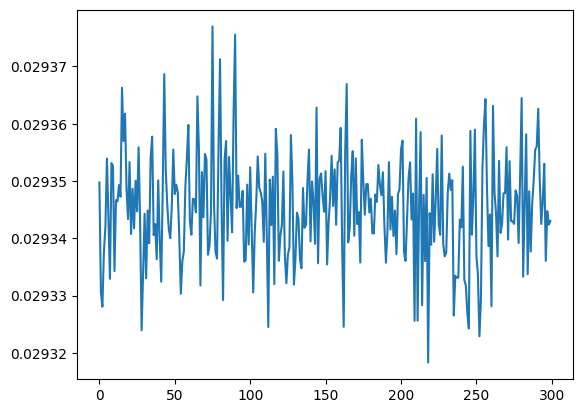

In [16]:
plt.plot(e1e2p[3, :, 0])

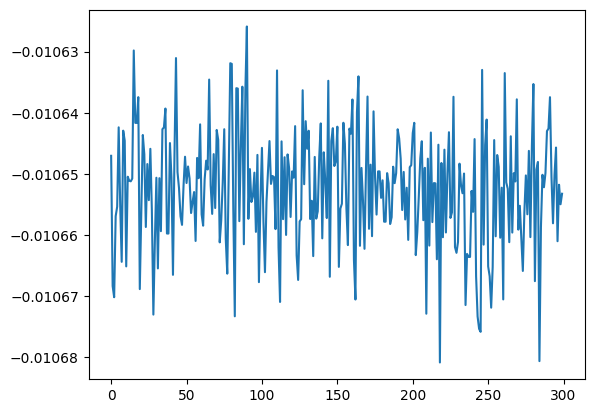

In [17]:
plt.plot(e1e2m[3, :, 0])

In [18]:
_pipe = partial(pipeline_shear_inference_simple,
                init_g=jnp.array([0.0,0.0]),
                sigma_e=sigma_e, 
                sigma_e_int=sigma_e_int,
                n_samples=3000,
                initial_step_size=0.01
               )
pipe = jit(_pipe)

In [19]:
e1e2p.shape

(10000, 300, 2)

In [20]:
gp_full = pipe(k2, e1e2p)

In [21]:
gm_full = pipe(k2, e1e2m)

In [22]:
gp_full.shape, gm_full.shape

((3000, 2), (3000, 2))

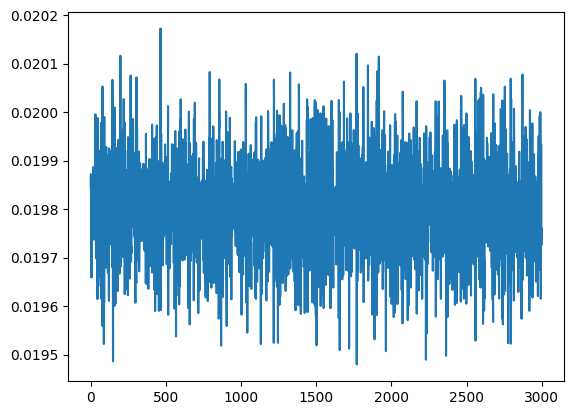

In [23]:
plt.plot(gp_full[:, 0])

In [26]:
(gp_full[:, 0].mean() - gm_full[:, 0].mean()) / 0.02 / 2 - 1

Array(-9.99296589e-05, dtype=float64)

In [30]:
gp_full[:, 0].std() / np.sqrt(len(gp_full[:, 0])), gm_full[:, 0].std() / np.sqrt(len(gm_full[:, 0]))

(Array(1.82786157e-06, dtype=float64), Array(1.82783566e-06, dtype=float64))

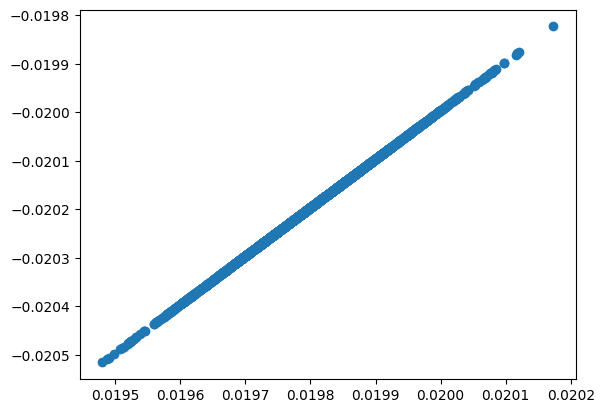

In [32]:
plt.scatter(gp_full[:, 0], gm_full[:, 0])

In [40]:
x = (gp_full[:, 0] - gm_full[:, 0]) / 2 / 0.02 - 1
x.mean(), x.std(), x.var()

(Array(-9.99296589e-05, dtype=float64),
 Array(1.8360536e-07, dtype=float64),
 Array(3.37109284e-14, dtype=float64))

array([[1.00265759e-08, 1.00264338e-08],
       [1.00264338e-08, 1.00262917e-08]])

In [39]:
_cov = np.cov(gp_full[:, 0], gm_full[:, 0])
var_m = (1 / (4 * 0.02**2)) * ( _cov[0,0] + _cov[1,1] - 2 * _cov[0, 1])
np.sqrt(var_m)

np.float64(1.8363596690277428e-07)

In [24]:
# # shear with bootstrap 
# n_boots = 100


# k2s = random.split(k2, (n_boots, 2) )

# e1e2p_boot = []
# e1e2m_boot = []

# for ii in tqdm(range(n_boots)):

#     _k1 = k2s[ii, 0 ]
#     indices = random.randint(_k1, minval=0, maxval=n_gals, shape=(n_gals,))
#     e1e2p_boot.append(e1e2p[indices])
#     e1e2m_boot.append(e1e2m[indices])

# e1e2p_boot = jnp.stack(e1e2p_boot, axis=0 )
# e1e2m_boot = jnp.stack(e1e2m_boot, axis=0)

100%|██████████| 100/100 [00:00<00:00, 401.01it/s]


In [35]:
# # run vectorized 
# gps = jax.vmap(pipe)(k2s[:, 1], e1e2p_boot)
# gms = jax.vmap(pipe)(k2s[:, 1], e1e2m_boot)

    
    

In [23]:
# shear with bootstrap 
n_boots = 100

gpsb = [] 
gmsb = [] 

k2s = random.split(k2, n_boots) 

for ii in tqdm(range(n_boots)):

    k_ii = k2s[ii]
    _k1, _k2 = random.split(k_ii)
    
    indices = random.randint(_k1, minval=0, maxval=n_gals, shape=(n_gals,))

    _e1e2p = e1e2p[indices]
    _e1e2m = e1e2m[indices]
    assert _e1e2p.shape[0] == n_gals
    
    _gp = pipe(_k2, _e1e2p)
    _gm = pipe(_k2, _e1e2m)

    gpsb.append(_gp)
    gmsb.append(_gm)
    
    

100%|██████████| 100/100 [13:10<00:00,  7.91s/it]


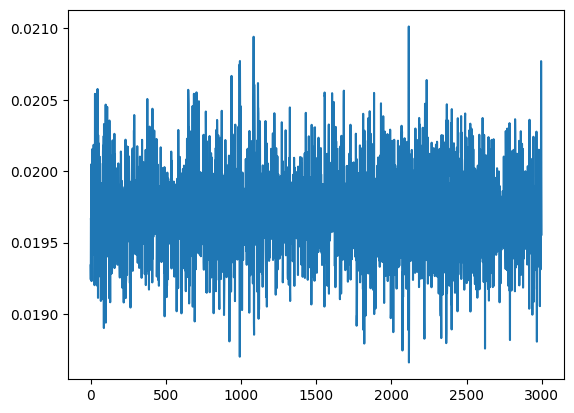

In [72]:
plt.plot(gspb_[14, :, 0])

In [25]:
gspb_ = jnp.stack(gpsb, axis=0)
gsmb_ = jnp.stack(gmsb, axis=0)
gspb_.shape

(100, 3000, 2)

(array([ 2.,  4.,  8.,  9., 28., 19., 13., 11.,  3.,  3.]),
 array([0.01893428, 0.01910051, 0.01926674, 0.01943297, 0.0195992 ,
        0.01976543, 0.01993166, 0.02009789, 0.02026412, 0.02043034,
        0.02059657]),
 <BarContainer object of 10 artists>)

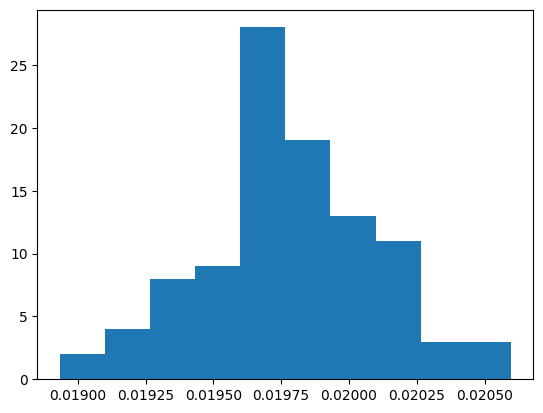

In [61]:
plt.hist(gspb_.mean(axis=1)[:, 0])

In [30]:
mboot = (gspb_[...,0].mean(axis=1) - gsmb_[...,0].mean(axis=1)) / 2 / 0.02 - 1
mboot.shape

(100,)

(array([ 1.,  0.,  1.,  1.,  0.,  0.,  2.,  3.,  5.,  3., 12., 18., 29.,
         4.,  7.,  1.,  6.,  4.,  1.,  1.,  1.]),
 array([-0.00126004, -0.0012388 , -0.00121756, -0.00119632, -0.00117508,
        -0.00115384, -0.0011326 , -0.00111136, -0.00109012, -0.00106888,
        -0.00104764, -0.0010264 , -0.00100516, -0.00098392, -0.00096268,
        -0.00094144, -0.0009202 , -0.00089896, -0.00087772, -0.00085648,
        -0.00083524, -0.000814  ]),
 <BarContainer object of 21 artists>)

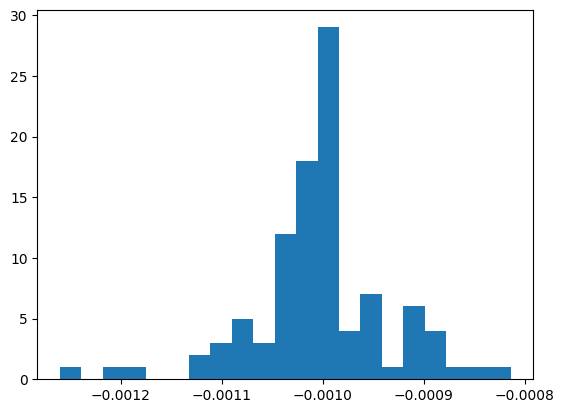

In [34]:
plt.hist(mboot, bins=21)

In [57]:
mfull = (gp_full[:, 0].mean() - gm_full[:, 0].mean()) / 2 / 0.02 - 1
mfull

Array(-0.00099629, dtype=float64)

In [32]:
mboot.mean()

Array(-0.0010037, dtype=float64)

In [39]:
mboot.std()

Array(6.75672383e-05, dtype=float64)

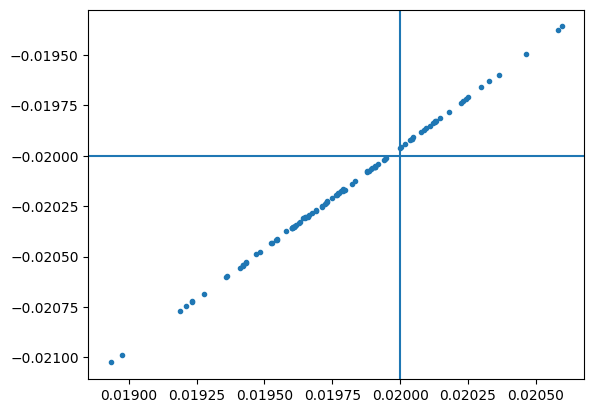

In [79]:
plt.plot(gspb_[:, :, 0].mean(1), gsmb_[:, :, 0].mean(1), '.')
plt.axvline(0.02)
plt.axhline(-0.02)

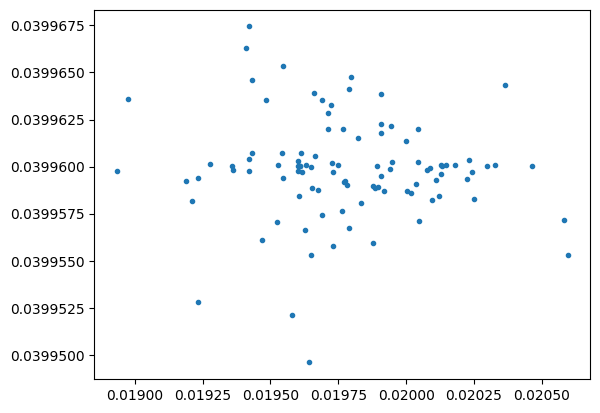

In [90]:
x = gspb_[:, :, 0].mean(1)
y = (gspb_[:, :, 0].mean(1) - gsmb_[:, :, 0].mean(1)) 
plt.plot(x, y, '.')

### Bootstrap but in chunks

In [40]:
# shear with bootstrap 
gps2 = [] 
gms2 = [] 

k21, k22 = random.split(k2) 

indices = random.permutation(k21, n_gals)

block_size = 100
splits = int(n_gals / block_size)
k22s = random.split(k22, splits)

for ii in tqdm(range(splits)):
    _k = k22s[ii]
    start, end = ii*block_size, (ii+1)*block_size
    _indices = indices[start:end]
    _e1e2p = e1e2p[_indices]
    _e1e2m = e1e2m[_indices]

    
    _gp = pipe(_k, _e1e2p)
    _gm = pipe(_k, _e1e2m)

    gps2.append(_gp)
    gms2.append(_gm)

    
    

100%|██████████| 10/10 [00:59<00:00,  5.96s/it]


In [44]:
gps2_ = jnp.stack(gps2, axis=0)
gms2_ = jnp.stack(gms2, axis=0)
gps2_.shape

(10, 3000, 2)

In [48]:
gps2_.mean(axis=1)[:, 0], gms2_.mean(axis=1)[:, 0]

(Array([0.01895981, 0.02021996, 0.01779577, 0.01936652, 0.01947568,
        0.01997231, 0.01987161, 0.02016848, 0.01995456, 0.02041217],      dtype=float64),
 Array([-0.02064176, -0.01939889, -0.02181666, -0.02023415, -0.02011793,
        -0.01962911, -0.01973512, -0.01943975, -0.01965357, -0.01919228],      dtype=float64))

In [50]:
mboot2 = (gps2_[...,0].mean(axis=1) - gms2_[...,0].mean(axis=1)) / 2 / 0.02 - 1
mboot2.shape

(10,)

In [51]:
mboot2

Array([-0.00996084, -0.00952865, -0.00968925, -0.00998338, -0.01015972,
       -0.0099644 , -0.00983184, -0.00979428, -0.00979688, -0.0098887 ],      dtype=float64)

In [56]:
mboot2.mean(), mboot2.std()

(Array(-0.00985979, dtype=float64), Array(0.00016583, dtype=float64))

In [55]:
mfull

Array(-0.00099629, dtype=float64)